<a href="https://colab.research.google.com/github/KhinSu2Hlaing/Image_Caption_Generator/blob/main/Image_Caption_Generator_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Img_Caption_Dataset'
WORKING_DIR = '/content/drive/MyDrive/Img_Caption_Dataset'

In [ ]:
directory = BASE_DIR

## Extract Image Feature

In [ ]:
# Load vgg16 Model
model_feature = VGG16()

# restructure model
model = Model(inputs = model_feature.inputs , outputs = model_feature.layers[-2].output)

# Summerize
print(model_feature.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8131 [00:00<?, ?it/s]

## Load the Captions Data

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
captions_path = '/content/drive/MyDrive/Img_Caption_Dataset/captions.txt'

In [ ]:
with open(os.path.join(captions_path, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

## split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

## Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

## Visualize the text before & after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Preprocessing Text Data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# No.of unique words
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train-Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
print(len(train))
print(len(test))
print(len(features))

7281
810
8131


In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Modeling

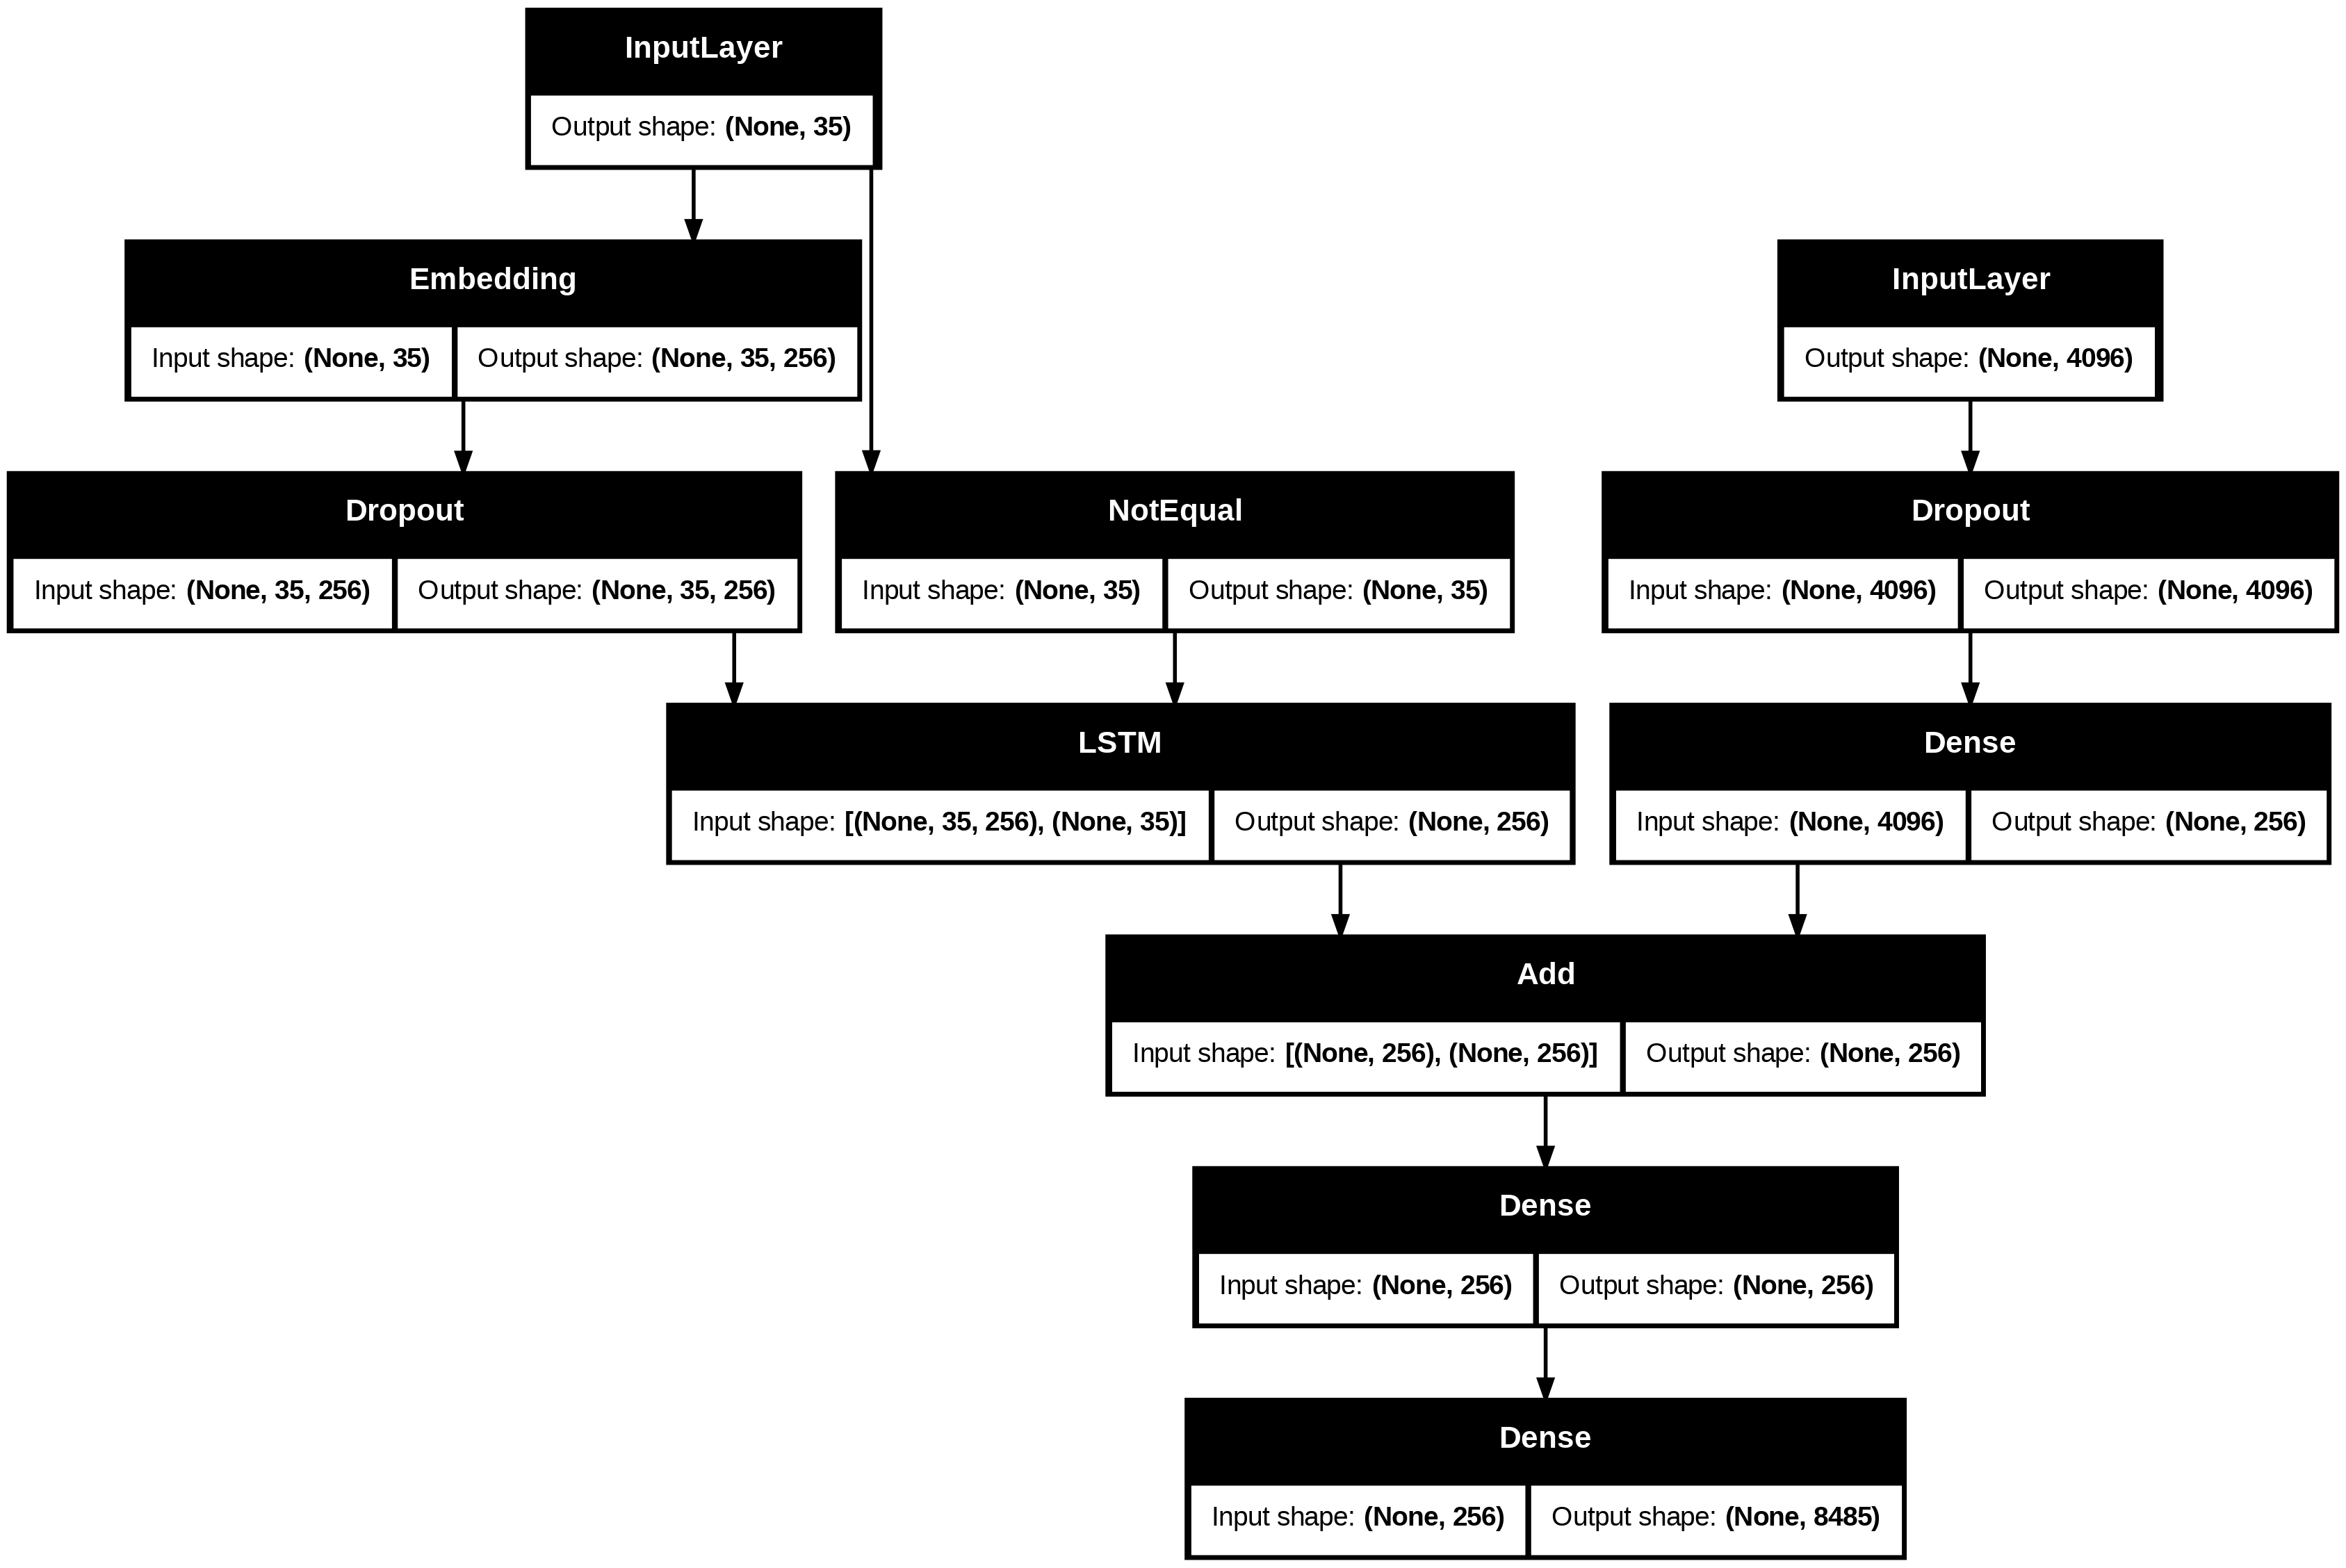

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

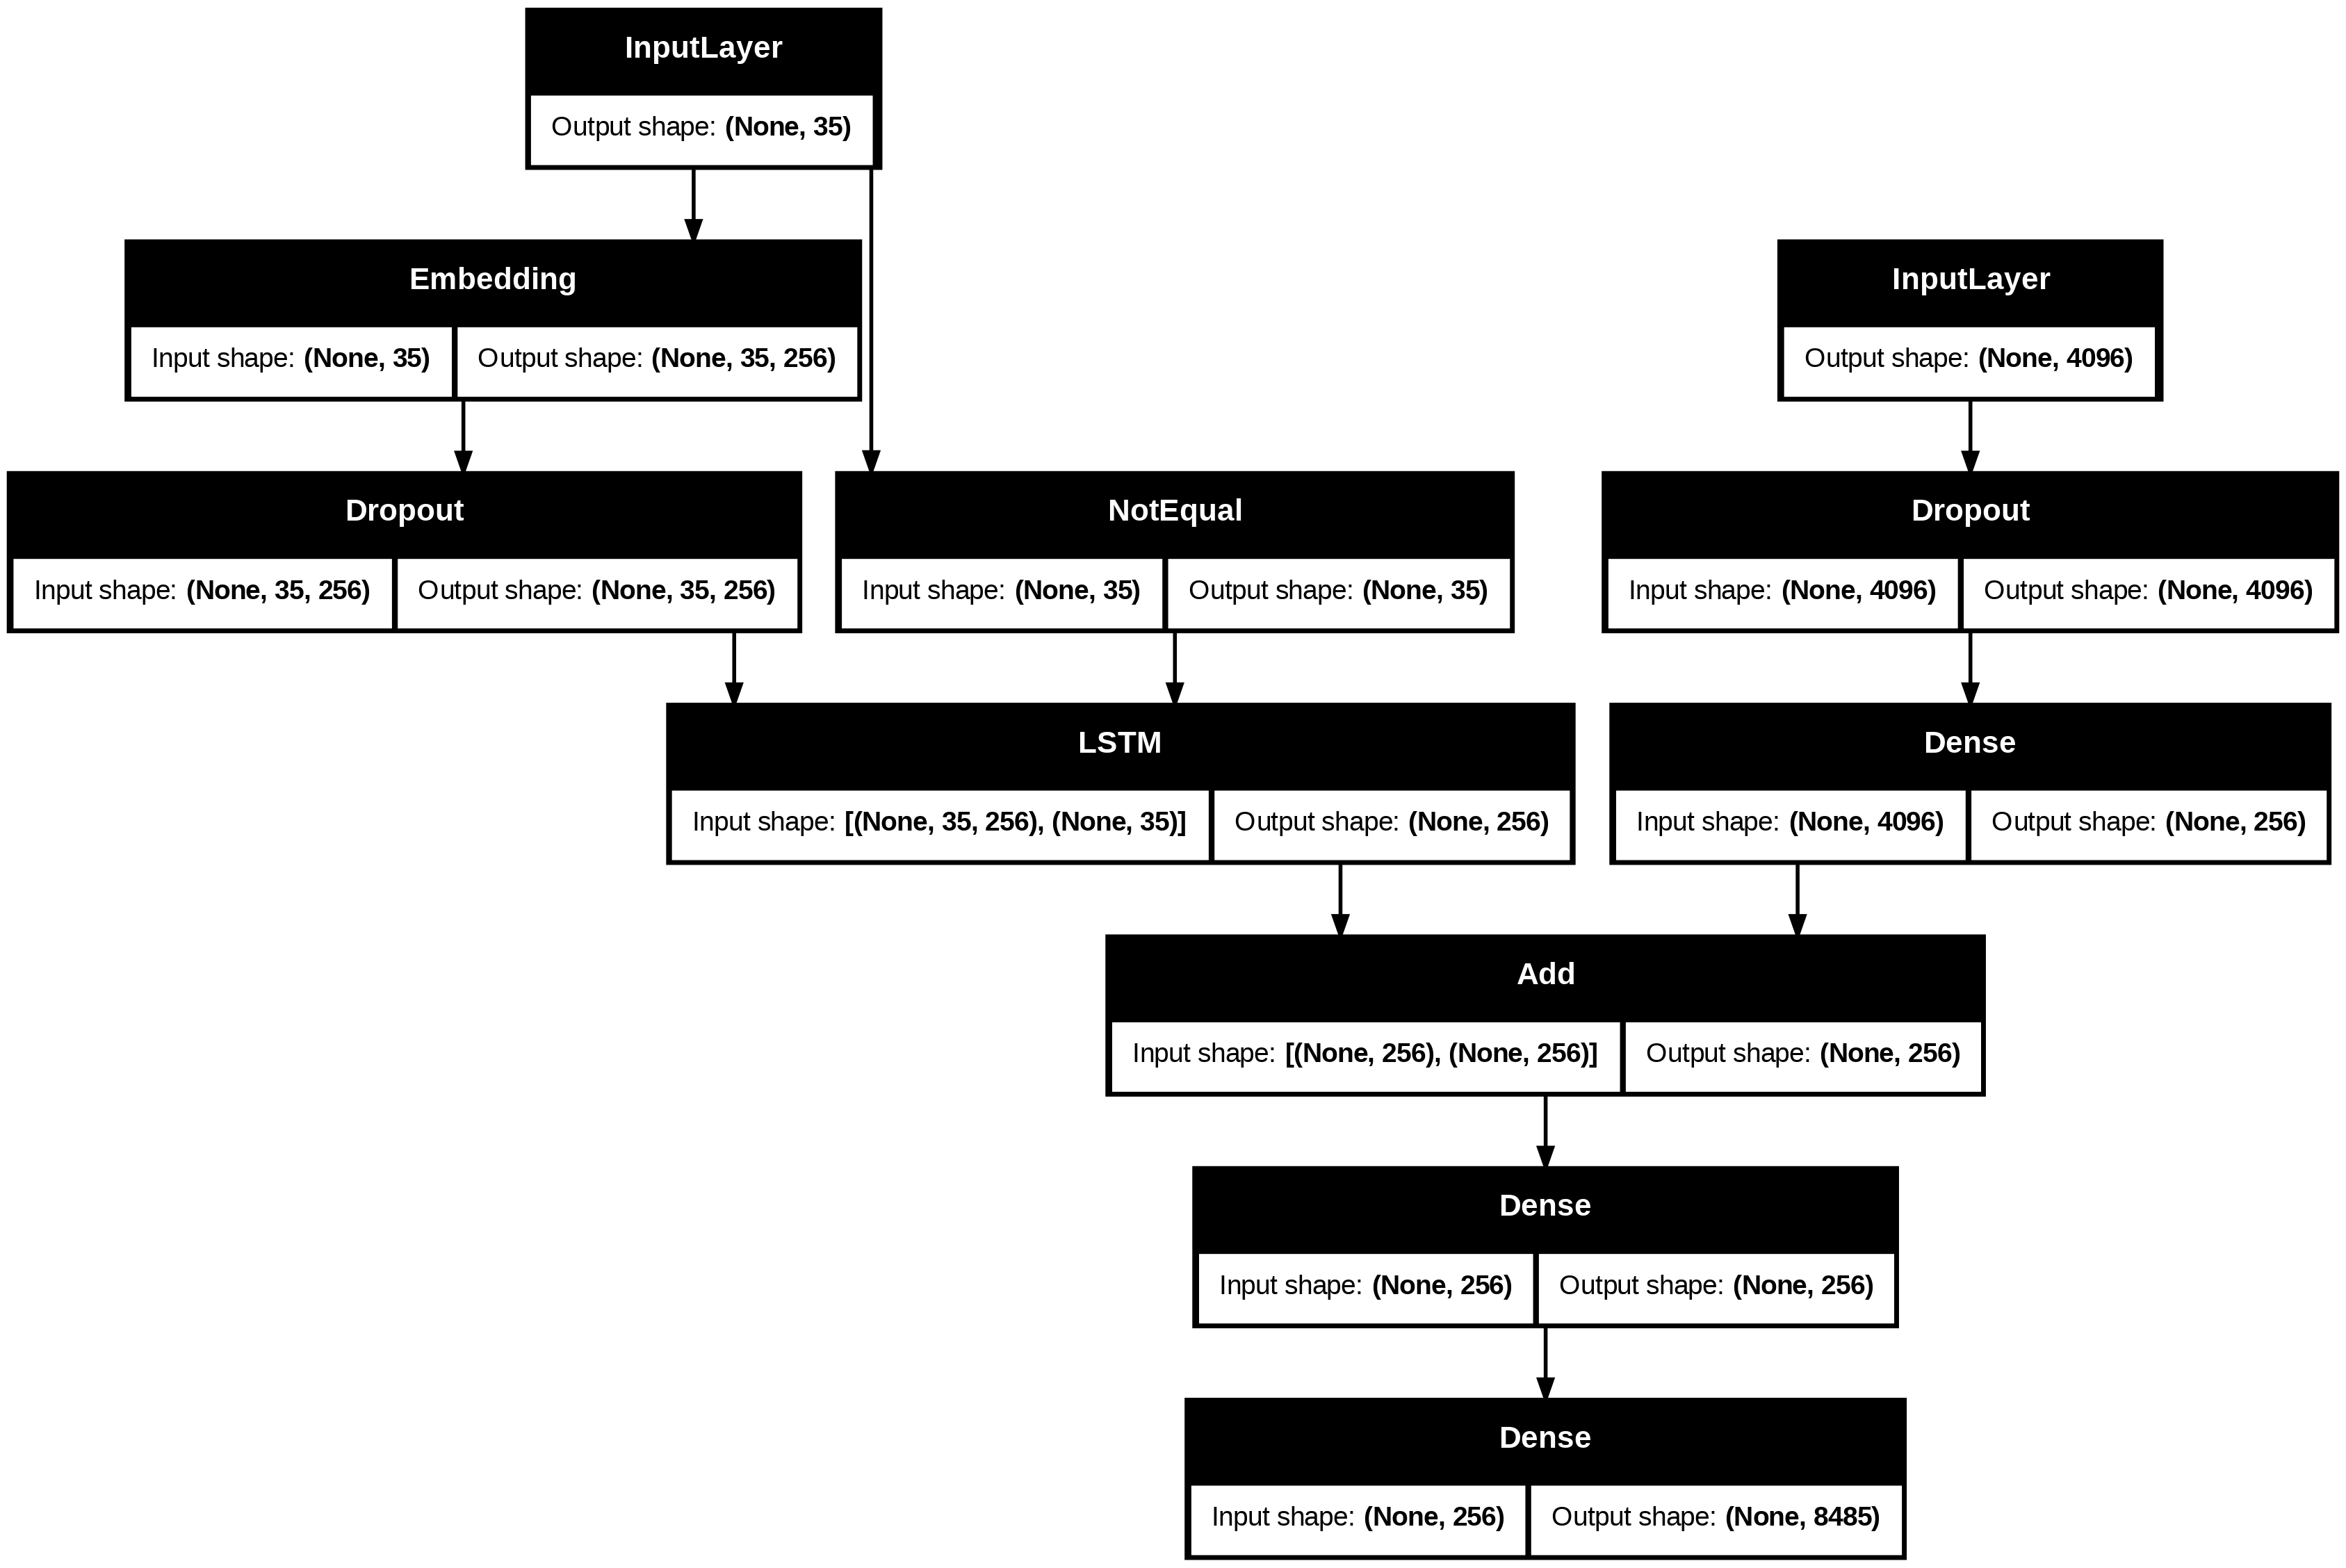

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.utils import plot_model

# Define the encoder input layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Define the sequence input layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  # Output shape: (batch_size, max_length, 256)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_bias=True, use_cudnn=False)(se2)  # Disabling cuDNN optimizations

# Define the decoder layers
decoder1 = add([fe2, se3])  # Ensure fe2 and se3 have the same shape (batch_size, 256)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

## Model Training

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Ensure X1 does not have an extra dimension
                    X1.append(features[key])  # Shape should be (4096,)
                    X2.append(in_seq)         # Shape should be (max_length,)
                    y.append(out_seq)         # Shape should be (vocab_size,)

                    # Yield batch when it's full
                    if len(X1) == batch_size:
                        # Convert lists to tensors and remove extra dimensions if necessary
                        X1_tensor = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
                        X2_tensor = tf.convert_to_tensor(np.array(X2), dtype=tf.int32)
                        y_tensor = tf.convert_to_tensor(np.array(y), dtype=tf.float32)

                        # Remove extra dimensions if present
                        if X1_tensor.ndim == 3:
                            X1_tensor = tf.squeeze(X1_tensor, axis=1)

                        yield (X1_tensor, X2_tensor), y_tensor

                        # Reset lists for the next batch
                        X1, X2, y = [], [], []

In [ ]:
example_key = next(iter(features.keys()))  # Get an arbitrary key from the dictionary
example_feature = features[example_key][0]  # Get the feature vector for this key
features_shape = example_feature.shape
print(features_shape)

(4096,)


In [ ]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size
print(len(train))

7281


In [ ]:
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),  # X1: image features
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2: padded sequences
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y: one-hot encoded output
)

In [ ]:
# Create the dataset
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

In [ ]:
import tensorflow as tf # import tensorflow
for i in range(epochs):
    # create data generator
    print(i)
    #generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    model.fit(dataset, epochs=1, steps_per_epoch=steps, verbose=1)

0
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 6.7013
1
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.0628
2
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.7493
3
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.3700
4
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 4.1363
5
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.9164
6
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.5868
7
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.3956
8
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.1577
9
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.0178
10
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.9042
11
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7726
12
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.5623
13
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.4652
14
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.3008
15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1817
16
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - los

## Model Saving

In [ ]:
# save the model
model.save(WORKING_DIR+'/my_best_model50.h5')

## Generate Captions for Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

## Model Validation using BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.419102
BLEU-2: 0.191224


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black dog and different breeds looking at each other on the road endseq


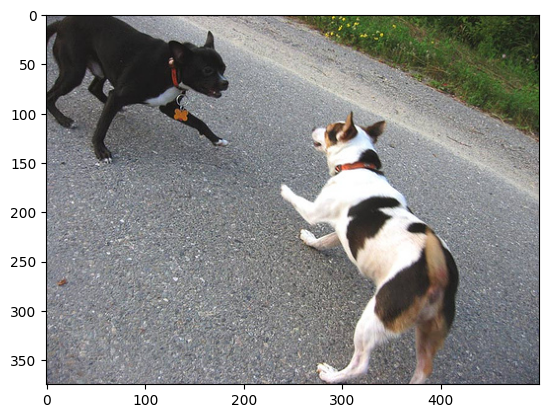

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in black is sitting next to modern art structure in front of glass building endseq
startseq man sits and reads newspaper by sculpture outside of an office building endseq
startseq man sits near large statue endseq
startseq man sitting in front of metal sculpture in front of building endseq
startseq the man with the backpack is sitting in buildings courtyard in front of an art sculpture reading endseq
--------------------Predicted--------------------
startseq man sits near an modern art courtyard near an sculpture reading endseq


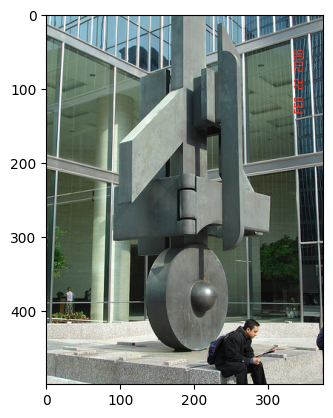

In [ ]:
generate_caption("103195344_5d2dc613a3.jpg")

---------------------Actual---------------------
startseq little girl looking at brochure on train rides endseq
startseq young blond girl with magizine in her hands endseq
startseq young girl on train reads book about train rides endseq
startseq young girl sits on seat and looks at train pamphlet endseq
startseq child sitting down looking at train ride brochure endseq
--------------------Predicted--------------------
startseq young girl looking at train hands at train pamphlet endseq


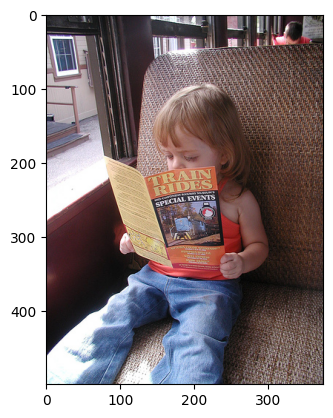

In [ ]:
generate_caption("1056359656_662cee0814.jpg")

In [ ]:
# Load the pre-trained VGG16 model to extract features
model_feature = VGG16()
model_vgg16 = Model(inputs=model_feature.inputs, outputs=model_feature.layers[-2].output)

def extract_features(image_path):
    # Load the image
    image = load_img(image_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for VGG16 model
    image = preprocess_input(image)
    # Extract features
    feature = model_vgg16.predict(image, verbose=0)
    return feature

In [ ]:
def generate_caption_for_real_image(image_path, model, tokenizer, max_length):
    # Extract features for the real-world image
    image_features = extract_features(image_path)

    # Generate the caption using the trained model
    in_text = 'startseq'
    for i in range(max_length):
        # Encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append the word as input for generating the next word
        in_text += ' ' + word
        # Stop if we reach the end tag
        if word == 'endseq':
            break

    # Remove the start and end tags from the final caption
    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)

Predicted Caption: two hikers is standing down top of cliff using big hill


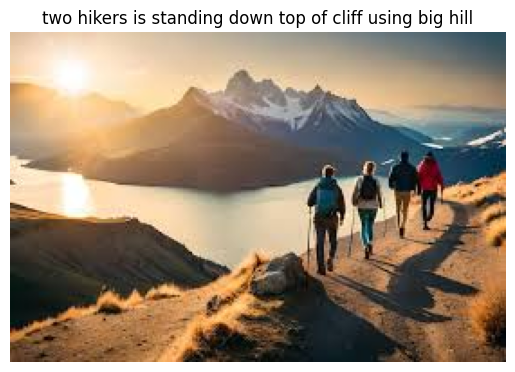

In [ ]:
# Test the model with a real-world image
real_image_path = '/content/mount1.jpg'  # Replace with your real image path
predicted_caption = generate_caption_for_real_image(real_image_path, model, tokenizer, max_length)
print('Predicted Caption:', predicted_caption)

import matplotlib.pyplot as plt
from PIL import Image

def display_image_and_caption(image_path, caption):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Display the real-world image with the predicted caption
display_image_and_caption(real_image_path, predicted_caption)

Predicted Caption: brown dog is running through the grass


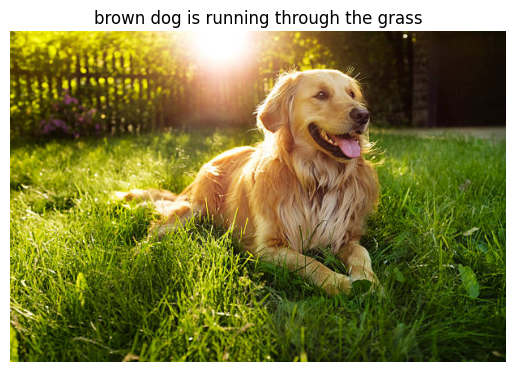

In [ ]:
# Test the model with a real-world image
real_image_path = '/content/test GR2.jpg'  # Replace with your real image path
predicted_caption = generate_caption_for_real_image(real_image_path, model, tokenizer, max_length)
print('Predicted Caption:', predicted_caption)

import matplotlib.pyplot as plt
from PIL import Image

def display_image_and_caption(image_path, caption):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Display the real-world image with the predicted caption
display_image_and_caption(real_image_path, predicted_caption)

Predicted Caption: man in blue soccer around while another man stands on the side of another bridge


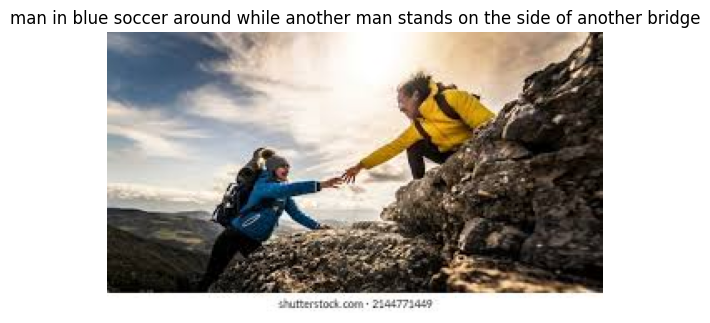

In [ ]:
# Test the model with a real-world image
real_image_path = '/content/2girls.jpg'  # Replace with your real image path
predicted_caption = generate_caption_for_real_image(real_image_path, model, tokenizer, max_length)
print('Predicted Caption:', predicted_caption)

import matplotlib.pyplot as plt
from PIL import Image

def display_image_and_caption(image_path, caption):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Display the real-world image with the predicted caption
display_image_and_caption(real_image_path, predicted_caption)

Predicted Caption: young boy is standing on the beach


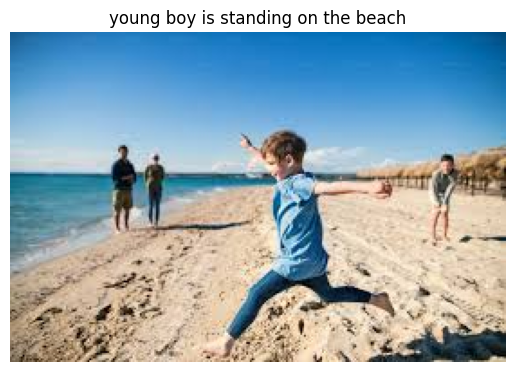

In [ ]:
# Test the model with a real-world image
real_image_path = '/content/beach boy.jpg'  # Replace with your real image path
predicted_caption = generate_caption_for_real_image(real_image_path, model, tokenizer, max_length)
print('Predicted Caption:', predicted_caption)

import matplotlib.pyplot as plt
from PIL import Image

def display_image_and_caption(image_path, caption):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Display the real-world image with the predicted caption
display_image_and_caption(real_image_path, predicted_caption)